In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt             
from collections import OrderedDict

In [2]:
#plot graph
def plotGaitAngle(list1,list2,list3):
    plt.plot(np.array(list1)) #blue R hip
    plt.plot(np.array(list2)) #orange R knee
    plt.plot(np.array(list3)) #green R ankle
    plt.ylabel('degree')
    plt.show()

#remove Nan from mylist
def crateListWithoutNan(mylist):
    newlist = []
    for i in mylist:
        if not pd.isnull(i):
            newlist.append(i)
    return newlist
    
class cameraKneeDataFrame:
    def __init__(self,df_pro,Vicon_rate = 100,camera_rate= 240):
        self.df_pro = df_pro
        if Vicon_rate > camera_rate:
            self.sampling_rate = camera_rate
            self.biggerValue = Vicon_rate
        else:
            self.sampling_rate = Vicon_rate
            self.biggerValue = camera_rate
        self.period = float(1/self.sampling_rate*self.biggerValue)
    #resampling mylist with new sampling rate
    def getNewSamplingList(self,mylist):
        reduced_list_len = float(len(mylist)/self.period)
        newlist = []
        for i in range(round(reduced_list_len)):
            if i*self.period<len(mylist):
                newlist.append(mylist[round(i*self.period)])
        return newlist

    
    def resamplingKneeList(self):
        self.cam_frame = self.getNewSamplingList(self.df_pro['frame'])
        self.cam_THIx = self.getNewSamplingList(self.df_pro['THIx'])
        self.cam_THIy = self.getNewSamplingList(self.df_pro['THIy'])
        self.cam_KNEx = self.getNewSamplingList(self.df_pro['KNEx'])
        self.cam_KNEy = self.getNewSamplingList(self.df_pro['KNEy'])
        self.cam_TIBx = self.getNewSamplingList(self.df_pro['TIBx'])
        self.cam_TIBy = self.getNewSamplingList(self.df_pro['TIBy'])
    
    def getKneeDataFrame(self):
        self.resamplingKneeList()
        new_camera_list =  OrderedDict([('THIx',self.cam_THIx),('THIy',self.cam_THIy),('KNEx',self.cam_KNEx)\
                                        ,('KNEy',self.cam_KNEy),('TIBx',self.cam_TIBx),('TIBy',self.cam_TIBy)])
        self.new_camera_df = pd.DataFrame.from_dict(new_camera_list)
        self.new_camera_df_list = self.new_camera_df.values.tolist()
        
        return self.new_camera_df 

#crate normalized knee angle        
def normalizeList(mylist,shift,Max):    
    newlist = []
    Max = Max + shift
    for i in mylist:
        i = (i+shift)/Max
        if i > 1: 
            i=1
        newlist.append(i)
    return newlist
def encodeList(mylist,shift,mul):
    newlist = []
    for i in mylist:
        i = int((i+shift)*mul)
        newlist.append(i)
    return newlist
#crate dataframe of dataset
class DataSet:
    def __init__(self,frameMatch,ViconDataIndex,new_camera_df_list,list_kneeAngleN):
        self.new_camera_df_list = new_camera_df_list
        self.kneeColumnN = list_kneeAngleN
        #match vicon amd cam then out put listX amd listY

        #Vicon match point index115
        #start 0 
        #end128

        #Camera match point index213
        #start 213-115 =98
        #end (128-115)+213= 226
        #check 226-98 = 128 ok
        self.viconstart = 0
        self.viconend = len(self.kneeColumnN)-1 #131
        self.camstart = frameMatch - ViconDataIndex
        self.camend = (self.viconend-ViconDataIndex)+frameMatch 
        self.diff = frameMatch-ViconDataIndex

        #pat = [
        #        [[0.3,0.4], [0.5]],
        #        [[0.3,0.5], [0.6]],
        #        [[0.4,0.5], [0.6]],
        #        [[0.9,0.3], [0.4]]
        #    ]
    def getList(self):
        self.pat = []
        if self.viconend - self.viconstart == self.camend-self.camstart:  
            for i in range(self.viconstart,self.viconend):
                a = self.new_camera_df_list[i+self.diff].copy()
                a.append(self.kneeColumnN[i])
                self.pat.append(a)    
            return self.pat
        else:
            print("array size error")
    def getDataFrame(self):
        self.getList()
        listOfDf= []
        header = ['THIx','THIy','KNEx','KNEy','TIBx','TIBy','knee angle']
        for i in self.pat:
            listOfDf.append( tuple(i))
        self.df = pd.DataFrame.from_records(listOfDf, columns=header)
        return self.df
        

In [28]:
#input function 

#User setup here
vicon_source = 'walking_gait_output_excel2/WALKING left 02.csv'
column_label = 15
camera_source = 'Knee_markers_excel/excelR10N.csv'
#User end

#input Vicon data
df = pd.read_csv(vicon_source,header=[column_label-1,column_label],engine='python',skip_blank_lines = False)
a = df.columns.get_level_values(0).to_series()
b = a.mask(a.str.startswith('Unnamed')).ffill().fillna('')
df.columns = [b, df.columns.get_level_values(1)]

#df = pd.read_csv(vicon_source,header=[column_label -1],engine='python',skip_blank_lines = False)
#df_np = np.array(df) 
#input camera data
df_pro = pd.read_csv(camera_source,sep = ',',engine='python')
df_pro_np = np.array(df_pro)   

In [29]:
df

LASI                                 RASI               \
     Field #           X            Y           Z           X            Y   
0         68  339.860687  1303.447266  923.042603   40.032772  1346.231079   
1         69  339.732452  1294.869873  921.116577   40.139599  1339.323608   
2         70  339.723633  1286.097168   919.19043    40.34745  1332.213745   
3         71  339.834778   1277.12915   917.26532   40.656681  1324.900513   
4         72  340.067535  1267.966187  915.343994   41.068321  1317.381836   
5         73  340.425018  1258.608521  913.432739   41.584644  1309.653687   
6         74  340.912445  1249.057617  911.542114   42.209663  1301.709839   
7         75  341.537079  1239.315918  909.688538   42.949547  1293.541626   
8         76   342.30838  1229.387573  907.894775   43.812824  1285.138672   
9         77  343.237793  1219.278564  906.190552    44.81041  1276.489014   
10        78  344.338104  1208.997437  904.611877   45.955437  1267.580322   
11        79  345.623108  1198.555176  903.200317   47.262833  1258.400757   
12        80  347.106445  1187.965454  902.001465    48.74868  1248.940308   
13        81  348.800842  1177.244263  901.062622   50.429321  1239.191528   
14        82  350.716858  1166.409912  900.429626   52.320343  1229.151245   
15        83  352.861572  1155.482666  900.143921   54.435429  1218.821167   
16        84  355.237457  1144.484619  900.238586   56.785168  1208.209595   
17        85  357.841217  1133.439453  900.734924   59.375809  1197.331421   
18        86  360.663116  1122.372925   901.63916   62.208073  1186.209595   
19        87  363.686829  1111.312134  902.940491   65.276009  1174.874634   
20        88  366.889984  1100.285889  904.609863   68.566109  1163.364014   
21        89  370.245148  1089.323853   906.60083   72.056938  1151.721436   
22        90  373.721558  1078.455444  908.851624   75.719383  1139.995483   
23        91  377.286652  1067.709473  911.288574   79.517509  1128.237671   
24        92  380.907867  1057.112305  913.831116   83.409798  1116.500732   
25        93  384.553833  1046.687256  916.396484   87.350815  1104.835693   
26        94  388.195221  1036.453735  918.905151   91.293098  1093.289917   
27        95  391.805328  1026.427246   921.28595   95.189308  1081.904541   
28        96  395.360077   1016.61908  923.480408   98.994453  1070.713257   
29        97  398.838409  1007.036499  925.446228  102.668121  1059.740601   
...      ...         ...          ...         ...         ...          ...   
2905    2031  159.561217   190.784265           0         200          300   
2906    2032  159.450701    190.78294           0         200          300   
2907    2033  159.478248   190.845039           0         200          300   
2908    2034  159.385107    190.85653           0         200          300   
2909    2035  159.486869   190.974269           0         200          300   
2910    2036   159.45057    190.75399           0         200          300   
2911    2037  159.333361   190.878052           0         200          300   
2912    2038  159.323589   190.962305           0         200          300   
2913    2039  159.317072   190.982224           0         200          300   
2914    2040  159.274453   191.069901           0         200          300   
2915    2041  159.221592   191.203624           0         200          300   
2916    2042  159.264241   191.246203           0         200          300   
2917    2043  159.214516   191.107629           0         200          300   
2918    2044   159.21625   191.168242           0         200          300   
2919    2045  159.141678   191.216225           0         200          300   
2920    2046   159.07681   191.332048           0         200          300   
2921    2047  159.087617   191.330138           0         200          300   
2922    2048  158.974945   191.317515           0         200          300   
2923    2049  159.039405   191.312162     

In [15]:
#Run this cell for right side
HipAngle = "RHipAngles"
KneeAngle = "RKneeAngles"
AnkleAngle = "RAnkleAngles"

In [17]:
#Run this cell for left side
HipAngle = "LHipAngles"
KneeAngle = "LKneeAngles"
AnkleAngle = "LAnkleAngles"

In [18]:
#check in put and crate list of normalized knee angle
print(df[HipAngle,"X"][0])#first hip angle
print(df[KneeAngle,"X"][0])#first Knee angle
print(df[AnkleAngle,"X"][0])#first ankle angle

#create list of knee angle with out nan
list_kneeAngle  = crateListWithoutNan(df["LKneeAngles","X"])

#crate normalized list of knee angle
#list_kneeAngleN = normalizeList(list_kneeAngle,10,50)

#encode
list_kneeAngleE = encodeList(list_kneeAngle,10,100)

22.257664000000002
-4.415087000000001
1.248215


In [27]:
list_kneeAngle

[-4.415087000000001,
 -4.958133999999999,
 -5.3761220000000005,
 -5.668979,
 -5.836627,
 -5.878557,
 -5.793723,
 -5.580033,
 -5.233493,
 -4.748267,
 -4.116453,
 -3.3291470000000003,
 -2.378643,
 -1.261042,
 0.019793,
 1.447865,
 2.991693,
 4.60324,
 6.221757,
 7.781821000000001,
 9.222919000000001,
 10.497108,
 11.573724,
 12.440263999999999,
 13.100285000000001,
 13.569366,
 13.869778,
 14.0262,
 14.062368,
 13.999654999999999,
 13.856576,
 13.649410000000001,
 13.392477,
 13.098711999999999,
 12.779684,
 12.445461,
 12.103886,
 11.759861,
 11.414603,
 11.065613,
 10.707216,
 10.331907000000001,
 9.932297,
 9.503219,
 9.043405,
 8.556442,
 8.050357,
 7.5365779999999996,
 7.027991,
 6.537297,
 6.075394999999999,
 5.650453,
 5.267537,
 4.928778,
 4.634027,
 4.381525,
 4.168948,
 3.994015,
 3.854911,
 3.7504779999999998,
 3.6799910000000002,
 3.6426230000000004,
 3.636904,
 3.6603220000000003,
 3.709172,
 3.7787040000000003,
 3.8635129999999998,
 3.958108,
 4.0576,
 4.158487,
 4.259162,


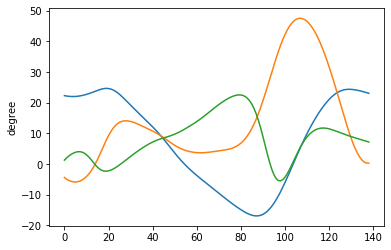

In [20]:
#display graph for matching
plotGaitAngle(df[HipAngle,"X"],df[KneeAngle,"X"],df[AnkleAngle,"X"])
#blue R hip
#orange R knee
#green R ankle

In [21]:
#crate pandas dataframe of camera data
#User setup here
Vicon_rate = 100
camera_rate = 240 #30fps * 8
frameMatch = 257 #approximate frame that is IC
ViconDataIndex = 53  #row of your value in excel minus first row in excel 
#User end


camKDF = cameraKneeDataFrame(df_pro)
#create camera dataframe
cam_df = camKDF.getKneeDataFrame()
#crate list if camera dataframe
cam_df_list = camKDF.new_camera_df_list


In [22]:
print(cam_df)

          THIx                THIy       KNEx                KNEy       TIBx  \
0         None                None       None                None       None   
1         None                None       None                None       None   
2         None                None       None                None       None   
3         None                None       None                None       None   
4         None                None       None                None       None   
5         None                None       None                None       None   
6         None                None       None                None       None   
7         None                None       None                None       None   
8         None                None       None                None       None   
9         None                None       None                None       None   
10        None                None       None                None       None   
11        None                None      

In [25]:
DS = DataSet(int(frameMatch/camKDF.period),ViconDataIndex,cam_df_list,list_kneeAngleE)
#create list of dataset
ds_list = DS.getList()
#create data set
ds_df = DS.getDataFrame()

In [24]:
#for i in ds_list:print(i)
print(ViconDataIndex)
print(frameMatch)
print(ds_list[ViconDataIndex])

53
257
['0.503125', '0.529891304347826', '0.5203125', '0.6168478260869565', '0.534375', '0.7309782608695652', 1492]


In [72]:
#save in excel
#User setup here
fileName = "walkR10.csv"
save_path = "matched_excel/"
#User end

ds_df.to_csv (save_path+fileName, index = None, header=True) 